In [48]:
import pandas as pd
import h5py
import numpy
import numpy as np
import pandas as pd
import re
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import gc
gc.collect()

from copy import deepcopy

def pclip(x, p):
    return np.clip(x, np.percentile(x, p), np.percentile(x, 100-p))

import os    
import subprocess

from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.preprocessing import *

import json

def rmse(ytrue, ypred):
    return np.mean((ytrue - ypred) ** 2) ** 0.5

In [20]:
TRAIN_FILE = "train.h5"
TEST_FILE = "test.h5"
BASELINE_WIENER = "baseline_wiener.csv"
BASELINE_KALMAN = "baseline_kalman.csv"
EMG_FILTER_LAG = 2

In [21]:
def score_trial(true_coordinates, predicted_coordinates, dimensions=2):
    return numpy.mean([pearsonr(numpy.diff(true_coordinates[:, axis]), 
                                numpy.diff(predicted_coordinates[:, axis]))[0] for
                       axis in range(dimensions)])

In [22]:
def write_solution(trial_indexes, trajectories, file_name):
    solution_list = numpy.vstack([
            [[subject_id, trial_index, tick, xy[0], xy[1]] for tick, xy in enumerate(trajectory)] for
            subject_id, trial_index, trajectory in zip(subject_ids, trial_indexes, trajectories)
        ])
    solution = pd.DataFrame.from_records(solution_list, columns=["subject_id", "trial_id", "tick_index", "x", "y"])
    solution.to_csv('submissions/'+file_name, index=False)

In [23]:
def plot_digit(coo, ax=None, title=''):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.plot(coo[:,0], coo[:,1], markersize=4, marker='.', )
    ax.plot(coo[:1,0], coo[:1,1], markersize=15, marker='.', color='red')
    ax.plot(coo[-1:,0], coo[-1:,1], markersize=15, marker='.', color='black')
    ax.set_title(title)
    ax.axis('equal')
    return ax

In [24]:
def unite(y1, y2):
    return np.vstack([y1[:len(y1) // 2], y2[len(y2) // 2:]])

In [25]:
def unite_(y1, y2):
    y1_, y2_ = np.diff(y1, axis=0), np.diff(y2, axis=0)
    y = np.vstack([y1_[:len(y1_) // 2], y2_[len(y2_) // 2:]])
    return np.cumsum(y, axis=0)

# Как выглядят данные EMG

EMG

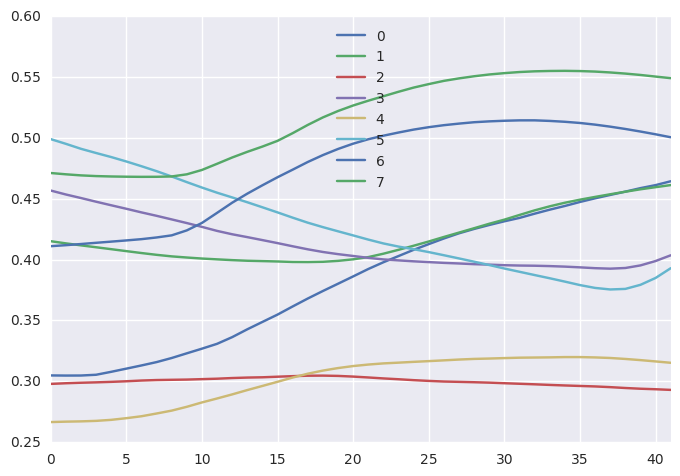

In [34]:
pd.DataFrame(emg_train_all[1]).plot()

приращения EMG

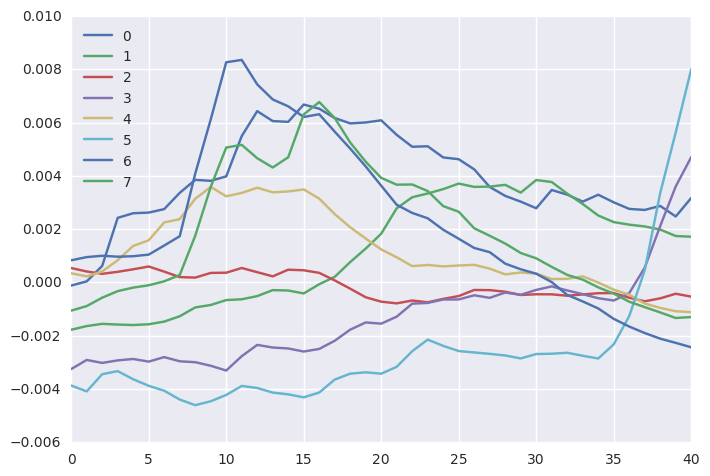

In [33]:
pd.DataFrame(np.diff(emg_train_all[1], axis=0)).plot()

# Соберем все данные со всех людей

In [26]:
subject_ids = []
trials = []
wiener = []
kalman = []
score_wiener_all, score_kalman_all = [], []
train_io = h5py.File(TRAIN_FILE, "r")
test_io = h5py.File(TEST_FILE, "r")
emg_train_all, emg_test_all, coo_train_all, coo_test_all, digits_test_all, subj_train, subj_test = \
    [], [], [], [], [], [], []
digits_train_all = []
for subject_id, subject_data in train_io.items():
    emg_list = []
    coordinates_and_diffs_list_all = []
    digits = []
    for digit, subject_trials in subject_data.items():
        for trial in subject_trials.values():
            coordinates_and_diffs_list_all.append(trial['pen_coordinates'])
            emg_list.append(numpy.array(trial['emg']))
            #digits.extend([int(digit)] * len(emg_list[-1]))
            digits += [digit]
            assert(trial['emg'].shape[0] == trial['pen_coordinates'].shape[0])
    
    coo_train_all.extend(coordinates_and_diffs_list_all)
    emg_train_all.extend(emg_list)
    digits_train_all.extend(digits)

In [27]:
len(coo_train_all), len(emg_train_all), len(digits_train_all)

(822, 822, 822)

# Если использовать исходное разбиение на трейн/тест, то предсказания легко получаются очень хорошими

In [255]:
print pd.DataFrame({'digit': digits_test, 'score': score}).groupby('digit').agg([np.mean, np.std])

          score          
           mean       std
digit                    
1      0.480401  0.139578
3      0.582855  0.350480
5      0.945936  0.045235
7      0.883433  0.034572
9      0.643651  0.399659


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


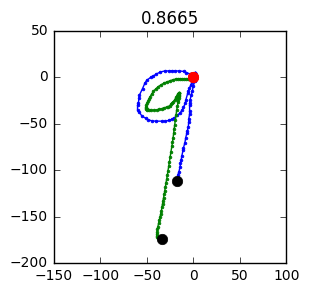

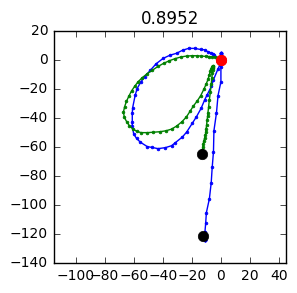

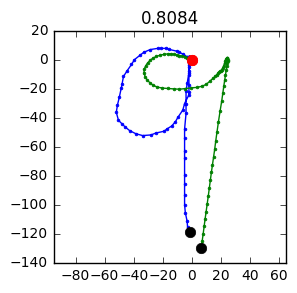

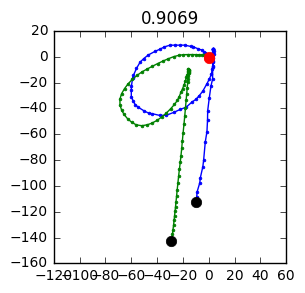

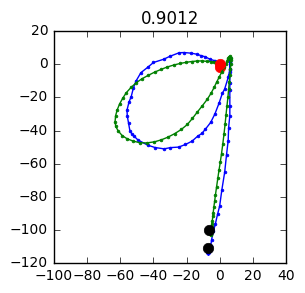

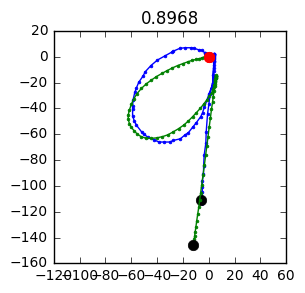

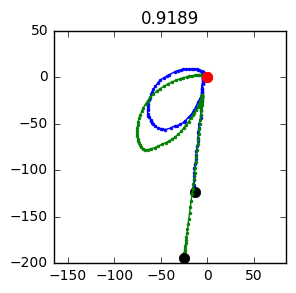

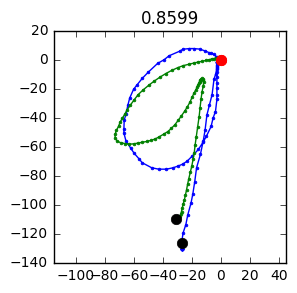

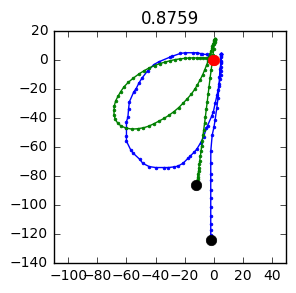

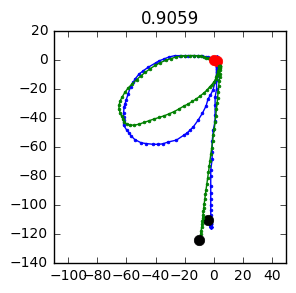

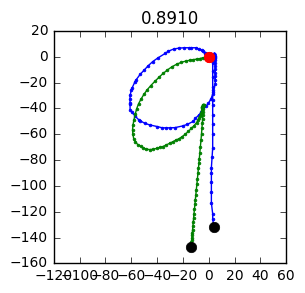

In [444]:
for trial_X, trial_y, trial_d in tqdm(zip(emg_test, coo_test, digits_test)[:50]):
    if trial_d == 9:
        Xte = get_X([trial_X])
        Xte = np.hstack([np.ones((len(Xte),1)) * 2, Xte])
        ypred = clf.predict(Xte)
        ypred = pd.DataFrame(ypred).cumsum().values

        ax = plot_digit(trial_y)
        plot_digit(ypred, ax=ax, title='{:.4f}'.format(score_trial(trial_y, ypred)))

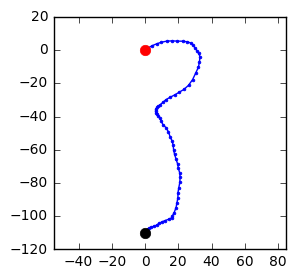

In [538]:
plot_digit(ypred)

# Идея - предсказывать в полярных координатах

In [28]:
from sklearn import neighbors
import sys
sys.path.insert(0, '/home/ubuntu/xgboost/python-package/')
import xgboost

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def vcart2pol(v):
    rho = np.sqrt(v[:,0]**2 + v[:,1]**2)
    phi = np.arctan2(v[:,1], v[:,0])
    #return np.vstack([rho, phi]).T
    return np.hstack([rho.reshape(-1,1), phi.reshape(-1,1)])

def vpol2cart(v):
    x = v[:,0] * np.cos(v[:,1])
    y = v[:,0] * np.sin(v[:,1])
    #return np.vstack([x, y]).T
    return np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [708]:
clf1.fit(Xtr, ytr)
print np.mean((yte - np.mean(ytr)) ** 2) ** 0.5, np.mean((clf1.predict(Xte) - yte) ** 2) ** 0.5

 3.42586456774 2.94377704183


In [709]:
clf1.fit(Xtr, ytr_)
print np.mean((yte_ - np.mean(ytr_)) ** 2) ** 0.5, np.mean((clf1.predict(Xte) - yte_) ** 2) ** 0.5

3.4848711312 2.8304013395


In [30]:
def all_diffs(x):
    x_ = []
    for i in range(x.shape[1]):
        for j in range(i+1, x.shape[1]):
            x_ += [x[:,[i]] - x[:,[j]]]
            
    return np.hstack(x_)

# считаем фичи от EMG и готовим y

In [29]:
def get_y(coo):
    ytr = []
    for i in coo:
        i = pd.DataFrame(np.array(i))
        i = (i - i.shift(1)).fillna(0)
        ytr += [i]

    return np.vstack(ytr)

приращения в полярных координатах - выбросы обрезаны

[None, None]

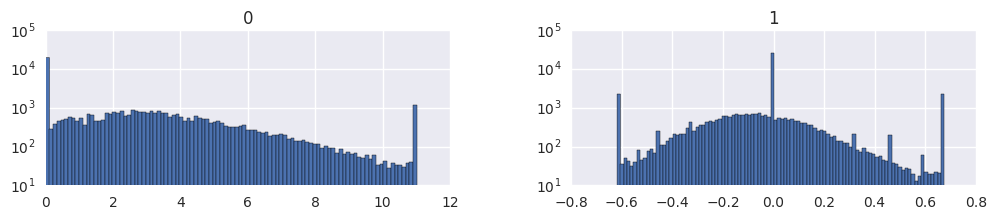

In [778]:
axes = pd.DataFrame(ytr__).hist(bins=100, figsize=(12,2))
[ax.set_yscale('log') for ax in axes[0]]

In [31]:
def get_X(emg_train, istrain=True):
    X = []
    for i in emg_train:
        Xtr = pd.DataFrame(np.array(i))
        Xtr_ = (Xtr-Xtr.shift(1)).fillna(0)
        Xtr_b = (Xtr-Xtr.shift(-1)).fillna(0)
        Xtr__ = (Xtr_-Xtr_.shift(1)).fillna(0)

        Xtr_diffs = pd.DataFrame(all_diffs(Xtr.values))
        Xtr_diffs_ = (Xtr_diffs-Xtr_diffs.shift(1)).fillna(0)
        Xtr_en = np.abs(Xtr_).ewm(alpha=0.2).mean()

        Xtr_di = Xtr_en-Xtr_#enb
        Xtr_di2 = Xtr_.ewm(alpha=0.2).mean() - Xtr_
        
        Xtr = np.hstack([Xtr_, Xtr_b, Xtr_diffs_, #np.linspace(0,1,len(Xtr)).reshape(-1,1),
                         Xtr_-Xtr_en, #Xtr_-Xtr_enb,
                         Xtr_di, Xtr_di2, #Xtr_di3,
                        ])
        
        Xtr = np.nan_to_num(Xtr)
        X += [Xtr]
    
    return np.vstack(X)

# кросс-валидация: leave one digit out

In [15]:
def scores_report():
    for D in sorted(scores.keys()):
        print '{:.2f} +- {:.2f}'.format(np.mean(scores[D]), np.std(scores[D]))

    print
    print '{:.2f} +- {:.2f}'.format(np.mean([np.mean(scores[k]) for k in scores.keys()]),
                                    np.std([np.mean(scores[k]) for k in scores.keys()]))

In [108]:
clf1 = ExtraTreesRegressor(150, n_jobs=-1)
clf2 = Ridge(alpha=1)
clf3 = neighbors.KNeighborsRegressor(n_neighbors=20)#, weights='distance')
clf4 = xgboost.XGBRegressor(n_estimators=60, max_depth=8, )
scores = {}

for D in sorted(np.unique(digits_train_all)):
    #print D
    
    tr_mask = np.arange(len(digits_train_all))[np.array([i!=D for i in digits_train_all])]
    te_mask = np.arange(len(digits_train_all))[np.array([i==D for i in digits_train_all])]
    
    
    Xtr = get_X([np.array(emg_train_all[n]) for n in tr_mask] + [np.array(emg_train_all[n])[::-1] for n in tr_mask])
    Xte = get_X([np.array(emg_train_all[n]) for n in te_mask])#+ [np.array(emg_train_all[n])[::-1] for n in te_mask])
    ytr = get_y([np.array(coo_train_all[n]) for n in tr_mask] + [np.array(coo_train_all[n])[::-1] for n in tr_mask])
    yte = get_y([np.array(coo_train_all[n]) for n in te_mask])# + [np.array(coo_train_all[n])[::-1] for n in te_mask])
    assert len(Xtr) == len(ytr)
    assert len(Xte) == len(yte)
    
    ytr = pclip(ytr, 0.1)

    clf1.fit(Xtr, ytr)#, sample_weight=1+np.abs(ytr__[:,1]) ** 0.3)# 1 + np.sum(ytr ** 2, axis=1) ** 0.5)
    clf2.fit(Xtr, ytr)
    pred_all4 = np.zeros((len(Xte), 2))
    for ysh in range(2):
        clf4.fit(Xtr, ytr[:,ysh], )#eval_set=[(Xte, yte[:,ysh])], early_stopping_rounds=5)
        pred_all4[:,ysh] = clf4.predict(Xte)
        
    pred_all = clf1.predict(Xte) + clf2.predict(Xte) + pred_all4

    l = 0
    score = []
    for n in te_mask:
        ytrue = coo_train_all[n]
        ypred = pred_all[l:l+len(ytrue)]
        ypred = pd.DataFrame(ypred).cumsum().values
        score += [score_trial(ytrue, ypred)]
        l += len(ytrue)

    scores[D] = score[:]
    
    print '{:.2f} +- {:.2f}'.format(np.mean(score), np.std(score))
    
print
print '{:.2f} +- {:.2f}'.format(np.mean([np.mean(scores[k]) for k in scores.keys()]),
                                np.std([np.mean(scores[k]) for k in scores.keys()]))

0.41 +- 0.20
0.61 +- 0.30
0.61 +- 0.19
0.69 +- 0.18
0.58 +- 0.12

0.58 +- 0.09


In [72]:
scores_report()

0.37 +- 0.19
0.61 +- 0.30
0.69 +- 0.17
0.73 +- 0.18
0.58 +- 0.13

0.60 +- 0.13


## идея - нагенерить больше примеров

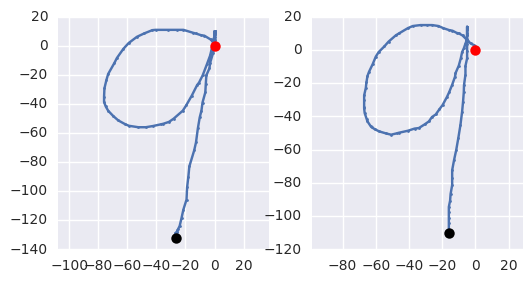

In [13]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
plot_digit(coo_train_all[219], ax=ax[0]) 
plot_digit(coo_train_all[220], ax=ax[1])

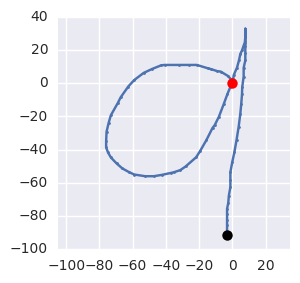

In [17]:
plot_digit(unite_(coo_train_all[219], coo_train_all[220]))

# Визуализация tsne для EMG каждой цифры

In [357]:
stats = []
for emg in emg_train_all:
    stats.append(np.hstack([emg.mean(axis=0),
                            emg.std(axis=0),
                            [np.corrcoef(emg[:,i], emg[:,j])[0,1] for i in range(8) for j in range(i+1,8)],
                           ]))

In [359]:
stats = np.array(stats)
stats.shape

(822, 44)

In [340]:
from sklearn.manifold import TSNE

In [360]:
tsne = TSNE()
stats_transformed = tsne.fit_transform(stats)

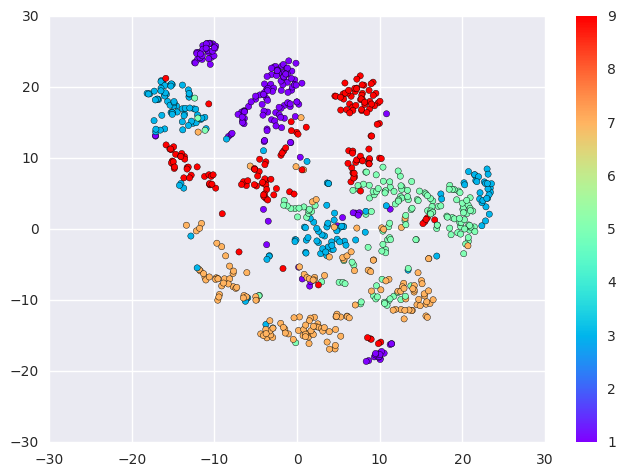

In [361]:
plt.scatter(stats_transformed[:,0], stats_transformed[:,1], c=digits_train_all, cmap='rainbow')
plt.colorbar()

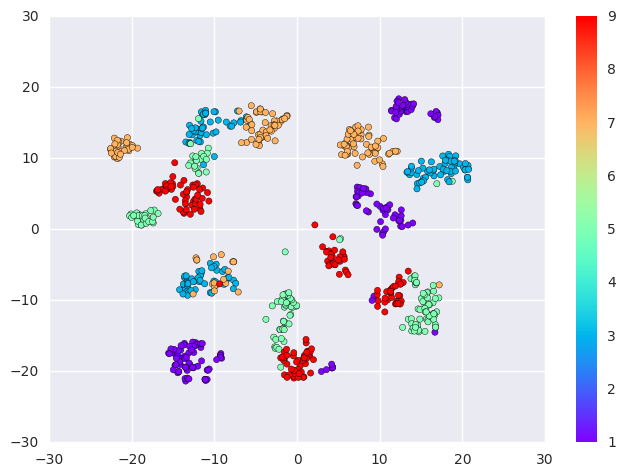

In [354]:
plt.scatter(stats_transformed[:,0], stats_transformed[:,1], c=digits_train_all, cmap='rainbow')
plt.colorbar()

# делаем сабмит

In [271]:
sbmt = []
shifts = [0, 1]
subject_ids = []
trials = []
trajectories = []
score_wiener_all, score_kalman_all = [], []
train_io = h5py.File(TRAIN_FILE, "r")
test_io = h5py.File(TEST_FILE, "r")
emg_list = []
digits = []
coordinates_and_diffs_list_all = []
for subject_id, subject_data in train_io.items():
    for digit, subject_trials in subject_data.items():
        for trial in subject_trials.values():
            coordinates_and_diffs_list_all.append(trial['pen_coordinates'])
            emg_list.append(numpy.array(trial['emg']))
            digits += [digit]
            assert(trial['emg'].shape[0] == trial['pen_coordinates'].shape[0])
    # Pred

clf1 = ExtraTreesRegressor(150, n_jobs=-1)
clf2 = Ridge()
#clf3 = neighbors.KNeighborsRegressor(n_neighbors=20)#, weights='distance')
clf4a = xgboost.XGBRegressor(n_estimators=60, max_depth=8, )
clf4b = xgboost.XGBRegressor(n_estimators=60, max_depth=8, )

Xtr, ytr = get_X(emg_list), get_y(coordinates_and_diffs_list_all)
clf1.fit(Xtr, ytr)
clf2.fit(Xtr, ytr)
#clf3.fit(Xtr, ytr)
clf4a.fit(Xtr, ytr[:,0], )
clf4b.fit(Xtr, ytr[:,1], )

for subject_id, subject_data in train_io.items():
    for trial_name, trial_data in tqdm(test_io[subject_id].items()):
        trials.append(get_tail_number(trial_name))
        subject_ids.append(get_tail_number(subject_id))
        Xte = get_X([trial_data])
                
        pred_all4 = np.zeros((len(Xte), 2))
        pred_all4[:,0] = clf4a.predict(Xte)
        pred_all4[:,1] = clf4b.predict(Xte)

        ypred = (clf1.predict(Xte) + clf2.predict(Xte) + pred_all4) / 3
        ypred = pd.DataFrame(ypred).cumsum().values
        trajectories += [ypred]
        #for ij,(x,y) in enumerate(ypred):
        #    sbmt += [(subject_id, trial_name, ij, x, y)]

100%|██████████| 277/277 [01:08<00:00,  4.03it/s]


In [272]:
write_solution(trials, trajectories, '3_11_field_warrior.csv')

# Посмотрим на предсказания

In [37]:
s = pd.read_csv('submissions/3_11_field_warrior.csv')

In [38]:
s[::10000]

,subject_id,trial_id,tick_index,x,y
0,0.0,107.0,0.0,0.032660,-0.195642
10000,0.0,316.0,76.0,69.870595,2.626914
20000,0.0,542.0,55.0,-38.877658,-59.754800
30000,0.0,821.0,61.0,-42.811273,-87.562979
40000,1.0,330.0,21.0,-3.909067,-6.130397
50000,1.0,538.0,83.0,41.888207,-24.525198
60000,1.0,747.0,34.0,-25.500621,-30.815142
70000,2.0,259.0,21.0,-4.652103,-9.096672
80000,2.0,496.0,56.0,-31.145243,-84.803667
90000,2.0,732.0,66.0,-24.604569,-71.857321


Результат: модель обучена на нечетных цифрах, 822 цифры в трейне. Средняя корреляция между (ypred_xy, ytrue_xy) около 0.6

Ниже предположительно: 4, 4, 6, 6, 6, 4, 6, 6, 6, 6 (в тесте все четные цифры)

(-200.0, 1200.0, -120.0, 40.0)

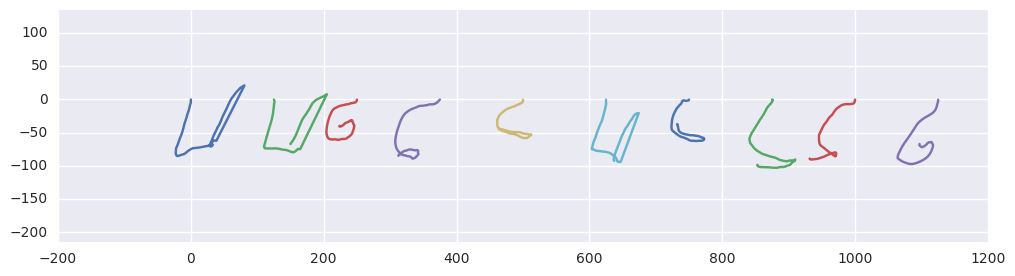

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
for i,row in s[::10000].iterrows():
    sliced = s[(s.subject_id == row['subject_id']) & (s.trial_id == row['trial_id'])]
     
    ax.plot(sliced.x + i/80, sliced.y)

ax.axis('equal')